*Exploratory Data Analysis*

# Understanding the Renderings from Virtual Cameras

In this notebook we visualize the camera poses during training and novel view generation.

In [1]:
%matplotlib notebook
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyArrow, ArrowStyle
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
import torch
import itertools
import json

from run_dnerf_helpers import get_rays
from utils.load_deepdeform import load_deepdeform_data, pose_spiral
from utils.load_owndataset import load_owndataset_data, quat_and_trans_2_trans_matrix

%load_ext autoreload
%autoreload 2

# Helper function
class Arrow3D(FancyArrowPatch):
    """https://stackoverflow.com/questions/47617952/drawing-a-righthand-coordinate-system-in-mplot3d"""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Load DeepDeform Data

In [2]:
scene_name = "gobblet"
datadir = "data/EXR_RGBD_s4"
SCENE_OBJECT_DEPTH=0.45
render_pose_type = "spherical"

images, depth_maps, poses, times, render_poses, render_times, hwff, i_split = load_owndataset_data(f"./data/{scene_name}", True, 1, render_pose_type=render_pose_type)
print('Loaded deepdeform', images.shape, render_poses.shape, hwff)

Scene Object Depth: 0.45
[Info] Data scaling factor: 0.744140625
Loaded deepdeform (93, 480, 360, 3) torch.Size([101, 4, 4]) [480, 360, 400.0368957519532, 400.0368957519531]


In [3]:
poses = torch.tensor(poses)
print(poses[0])
#plt.imshow(images[0])
#plt.imshow(depth_maps[0])
#print(render_poses[0])

tensor([[ 0.9634, -0.0691, -0.2591, -0.1829],
        [ 0.0034,  0.9692, -0.2461,  0.1103],
        [ 0.2682,  0.2362,  0.9340,  0.5102],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Get some rays for the first pose (code in `from run_dnerf_helpers import get_rays`):

In [4]:
pose = poses[0]
render_pose = render_poses[0]
#print("First novel camera pose to be rendered:\n", render_pose)
#print("Camera pose of the training images:\n", poses[0])

# Implemented in get_rays(H, W, focal, c2w) function

c2w = pose[:3]
c2w2 = render_pose[:3]

print(c2w)
print("=====")
print(c2w2)
H, W, focal_x, focal_y = hwff

# Create coordinates for each pixel in the camera coordinate system
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H), indexing='ij')      # shape [240, 320], [240, 320]
i = i.t()           # pixel coordinates in X-dir
j = j.t()           # in Y-dir
# The ray directions in the camera coordinate system. 
# Center the X- and Y-coordinates to the image center and scale by focal length. The rays go in the negative Z direction.
dirs = torch.stack([(i-W*.5)/focal_x, -(j-H*.5)/focal_y, -torch.ones_like(i)], -1)                                          # shape [240, 320, 3]

# Rotate ray directions from camera frame to the world frame
rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
# Translate camera frame's origin to the world frame. It is the origin of all rays.
rays_o = c2w[:3,-1].expand(rays_d.shape)

print("Ray directions shape:", rays_d.shape)
print("Ray origins shape:", rays_o.shape)
print("Ray direction for pixel [0,0] is", rays_d[0,0].tolist(), "with origin at", rays_o[0,0].tolist())

tensor([[ 0.9634, -0.0691, -0.2591, -0.1829],
        [ 0.0034,  0.9692, -0.2461,  0.1103],
        [ 0.2682,  0.2362,  0.9340,  0.5102]])
=====
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.6047]])
Ray directions shape: torch.Size([480, 360, 3])
Ray origins shape: torch.Size([480, 360, 3])
Ray direction for pixel [0,0] is [-0.21583062410354614, 0.8260934352874756, -0.9128983020782471] with origin at [-0.18290284276008606, 0.11034248024225235, 0.5101594924926758]


Plot the coordinate frames and the rays.

<IPython.core.display.Javascript object>


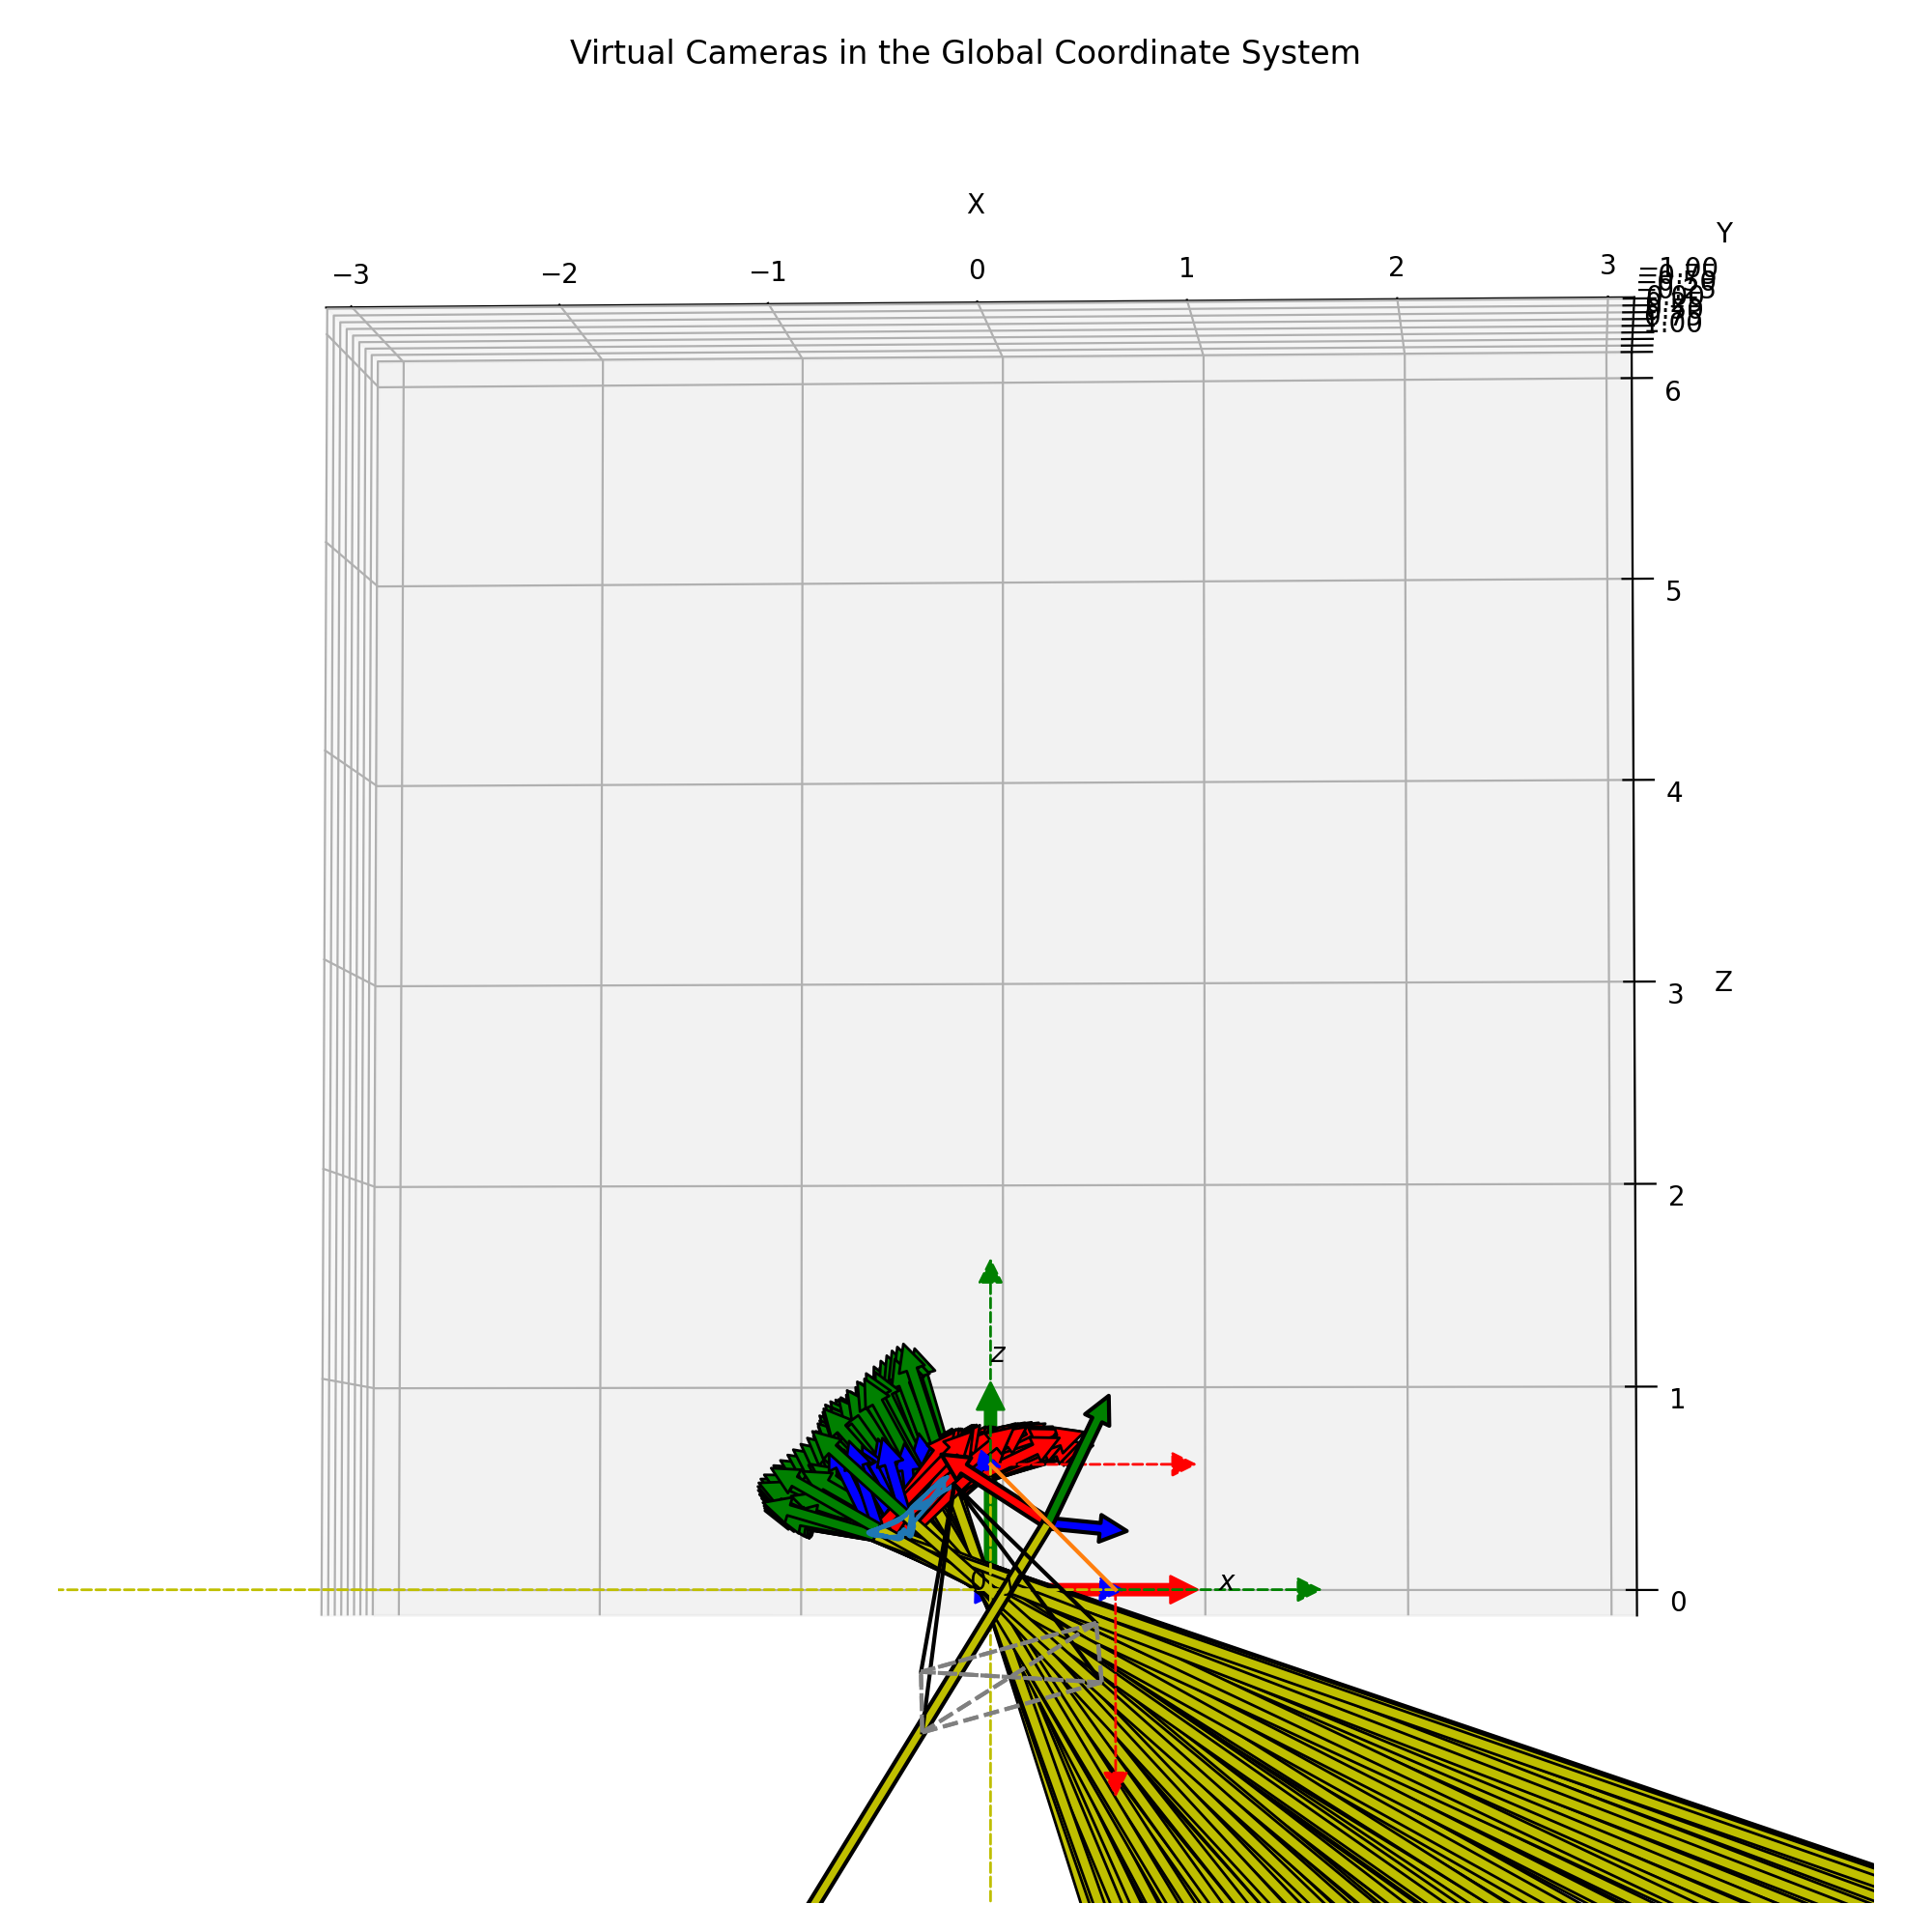

tensor([-0.1829,  0.1103,  0.5102])
tensor([-0.1974,  0.1045,  0.4977])
tensor([-0.2125,  0.0968,  0.4871])
tensor([-0.2466,  0.0838,  0.4734])
tensor([-0.2581,  0.0733,  0.4637])
tensor([-0.2825,  0.0592,  0.4458])
tensor([-0.3038,  0.0581,  0.4262])
tensor([-0.3121,  0.0580,  0.4166])
tensor([-0.3216,  0.0583,  0.4081])
tensor([-0.3327,  0.0644,  0.3985])
tensor([-0.3457,  0.0702,  0.3946])
tensor([-0.3587,  0.0779,  0.3942])
tensor([-0.3718,  0.0855,  0.3971])
tensor([-0.3828,  0.0993,  0.3966])
tensor([-0.3902,  0.1283,  0.3873])
tensor([-0.3944,  0.1436,  0.3849])
tensor([-0.3921,  0.1584,  0.3786])
tensor([-0.3906,  0.1784,  0.3711])
tensor([-0.3922,  0.2027,  0.3648])
tensor([-0.3944,  0.2306,  0.3560])
tensor([-0.3932,  0.2561,  0.3438])
tensor([-0.3904,  0.2908,  0.3088])
tensor([-0.3954,  0.3038,  0.2916])
tensor([-0.4003,  0.3126,  0.2756])
tensor([-0.4044,  0.3188,  0.2627])
tensor([-0.4114,  0.3280,  0.2590])
tensor([-0.4179,  0.3398,  0.2617])
tensor([-0.4360,  0.3708,  0

In [5]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

xlim = [-3, 3]
ylim = [-1, 1]
zlim = [0, 6]
#xlim = [-1.5, 1.5]
#ylim = [-1.5, 1.5]
#zlim = [0, 6]
ax1.set_xlabel('X')
ax1.set_xlim(*xlim)
ax1.set_ylabel('Y')
ax1.set_ylim(*ylim)
ax1.set_zlabel('Z')
ax1.set_zlim(*zlim)
ax1.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))       # -> length of 1 in each dimension is visually the equal

# The world coordinate system
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='simple', shrinkA=0, shrinkB=0)
ax1.add_artist(Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
ax1.add_artist(Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict, color='b'))
ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict, color='g'))
ax1.text(-.1, -.1, 0.0, r'$0$')
ax1.text(1.1, 0, 0, r'$x$')
ax1.text(0, 1.1, 0, r'$y$')
ax1.text(0, 0, 1.1, r'$z$')

def draw_transformed(c2w, ax, axes_len=1.0, edgecolor=None, **kwargs):
    """Draw the camera coordinate frame. Camera-to-world transformation."""
    # R = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ c2w[:3, :3]
    R = c2w[:3, :3]
    # new_o = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ c2w[:3, 3]
    new_o = c2w[:3, 3]# + torch.tensor([0,0,3])
    print(new_o)
    new_x = R @ np.array([axes_len, 0, 0]) + new_o
    new_y = R @ np.array([0, axes_len, 0]) + new_o
    new_z = R @ np.array([0, 0, axes_len]) + new_o
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', shrinkA=0, shrinkB=0, fill=True)
    arrow_prop_dict.update(**kwargs)
    arrx = ax.add_artist(Arrow3D([new_o[0], new_x[0]], [new_o[1], new_x[1]], [new_o[2], new_x[2]], **arrow_prop_dict, facecolor='r', edgecolor=edgecolor if edgecolor else "r"))
    arry = ax.add_artist(Arrow3D([new_o[0], new_y[0]], [new_o[1], new_y[1]], [new_o[2], new_y[2]], **arrow_prop_dict, facecolor='b', edgecolor=edgecolor if edgecolor else "b"))
    arrz = ax.add_artist(Arrow3D([new_o[0], new_z[0]], [new_o[1], new_z[1]], [new_o[2], new_z[2]], **arrow_prop_dict, facecolor='g', edgecolor=edgecolor if edgecolor else "g"))
    arr_minusz = ax.add_artist(Arrow3D([new_o[0], -20*new_z[0]], [new_o[1], -20*new_z[1]], [new_o[2], -20*new_z[2]], **arrow_prop_dict, facecolor='y', edgecolor=edgecolor if edgecolor else "y"))
    return arrx, arry, arrz, new_o

def draw_cam(rays_o, rays_d, ax):
    H, W, _ = rays_d.shape
    ps = []
    # plot camera rays
    for iy, ix in [[0, 0], [H-1, 0], [0, W-1], [H-1, W-1]]:
        # o = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ rays_o[iy, ix]
        # d = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ rays_d[iy, ix]
        o = rays_o[iy, ix]
        d = rays_d[iy, ix]
        p = o + d
        ax.plot([o[0], p[0]], [o[1], p[1]], [o[2], p[2]], color="black")
        ps.append(p)
    # plot camera frame
    for p1, p2 in list(itertools.permutations(ps, 2)):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color="grey", ls="--")

# Draw novel camera coordinate frames
new_os = []
i=0
for pose in poses[::]:
    if i%1==0:
        rcx, rcy, rcz, new_o = draw_transformed(pose, ax1, arrowstyle='simple', axes_len=0.7, linewidth=1., mutation_scale=20, edgecolor="black")
        new_os.append(new_o)
    i+=1

ax1.plot([n[0] for n in new_os], [n[1] for n in new_os], [n[2] for n in new_os])

new_os_render = []
i=0
for render_pose in render_poses[::]:
    if i%100==0:
        rcx, rcy, rcz, new_o = draw_transformed(render_pose, ax1, linestyle="--")
        new_os_render.append(new_o)
    i+=1

ax1.plot([n[0] for n in new_os_render], [n[1] for n in new_os_render], [n[2] for n in new_os_render])



# Draw the init pose coordinate frame
with open(datadir + "/metadata.json", "r") as f:
        metas = json.load(f)
        init_pose = quat_and_trans_2_trans_matrix(np.array(metas["initPose"]).astype(np.float32))
        init_pose[2,3] += SCENE_OBJECT_DEPTH
tcx, tcy, tcz, _ = draw_transformed(init_pose, ax1, arrowstyle='simple', axes_len=0.7, linewidth=1.5, mutation_scale=20, edgecolor="black")

"""
lgnd1 = plt.legend(handles=[tcx, tcy, tcz], 
           labels=["X", "Y", "Z"], 
           title="Training camera pose", loc=1)
plt.legend(handles=[Line2D([0], [0], color='r', ls="--"), 
                    Line2D([0], [0], color='b', ls="--"), 
                    Line2D([0], [0], color='g', ls="--"), 
                    Line2D([0], [0], color='black', ls="-"),
                    Line2D([0], [0], color='grey', ls="--")], 
           labels=["X", "Y", "Z", "Rays of 0th camera", "0th camera image"], 
           title="Novel view cameras", loc=2)
plt.gca().add_artist(lgnd1)
"""

draw_cam(rays_o, rays_d, ax1)       # rays_o and rays_d are already in world-coordinates

fig.suptitle("Virtual Cameras in the Global Coordinate System", )
fig.tight_layout()

plt.show()